In [1]:
%load_ext autoreload
%autoreload 2

# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) with the associated [github](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py).

## Imports 

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from functools import partial

from sklearn.metrics import r2_score  
import os
import sys
import numpy as np
import haiku as hk
import jax
import optax

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 01_cvae.ipynb --output=01_cvae_2.ipynb --ExecutePreprocessor.timeout=-1




[cuda(id=0), cuda(id=1)]

In [3]:
from evoscaper.model.vae import CVAE, sample_z, VAE_fn
from evoscaper.model.mlp import MLP
from evoscaper.model.shared import arrayise
from evoscaper.model.loss import loss_wrapper, compute_accuracy_regression, mse_loss, accuracy_regression
from evoscaper.utils.math import convert_to_scientific_exponent
from evoscaper.utils.optimiser import make_optimiser
from evoscaper.utils.train import make_saves
from common import balance_dataset, balance_dataset2d

## Load data

In [4]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_csv(fn)
len(data)

600000

In [5]:
data['adaptability'] = calculate_adaptation(
    s=data['sensitivity_wrt_species-6'].values, 
    p=data['precision_wrt_species-6'].values)

## Hyperparameters

In [6]:
# Stats
SEED = 1
PRNG = jax.random.PRNGKey(SEED)

# Architecture
USE_SIGMOID_DECODER = False
HIDDEN_SIZE = 32 # 64
ENC_LS = 64
DEC_LS = 64
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3
enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 

# Dataset 
# OBJECTIVE_COL = 'sensitivity_wrt_species-6'
OBJECTIVE_COL = 'adaptability'
include_diffs = False
X_TYPE = 'energies'  # 'binding_rates_dissociation' #  
# OUTPUT_SPECIES = ['RNA_1', 'RNA_2']
OUTPUT_SPECIES = ['RNA_2']

# Dataset training
BATCH_SIZE = 128
SCALE_X_MINMAX = True
SCALE_Y_MINMAX = True
TOTAL_DS = None
TOTAL_DS_MAX = 3e6
N_BATCHES = int(TOTAL_DS_MAX // BATCH_SIZE)
USE_X_LOGSCALE = False
USE_Y_LOGSCALE = False
USE_Y_CATEGORICAL = False
USE_X_NEG = True

# Training
EPOCHS = 500
LEARNING_RATE = 1e-2
LEARNING_RATE_SCHED = 'cosine_decay'  # 'constant
TRAIN_SPLIT = 0.8
USE_DROPOUT = False
USE_L2_REG = False
USE_KL_DIV = False
USE_WARMUP = True
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
PRINT_EVERY = EPOCHS // 100

# Loss
loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG, use_kl_div=USE_KL_DIV) 
compute_accuracy = compute_accuracy_regression

# Save 
TASK = '_no_KL'
# TASK = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + TASK
save_path = os.path.join('weight_saves', '01_cvae', save_path)
X_COLS = list(get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True))
if include_diffs:
    X_COLS = X_COLS + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, X_TYPE, remove_symmetrical=True)]]



# Initialise

## Init data

In [7]:
filt = data['sample_name'].isin(OUTPUT_SPECIES) & ~data['precision_wrt_species-6'].isna() & ~data['sensitivity_wrt_species-6'].isna() & (data['precision_wrt_species-6'] < np.inf) & data[OBJECTIVE_COL].notna()

# Balance the dataset
df = data[filt]
# df = drop_duplicates_keep_first_n(df, get_true_interaction_cols(
#     data, X_TYPE, remove_symmetrical=True), n=100)
df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))

if TOTAL_DS is None:
    TOTAL_DS = len(df)

df = df.reset_index(drop=True)


/tmp/ipykernel_2406306/3003755888.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[772.4 784.  775.1 ... 724.3 722.3 683. ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))


### Subsample overrepresented points

Text(0, 0.5, 'Energies mean')

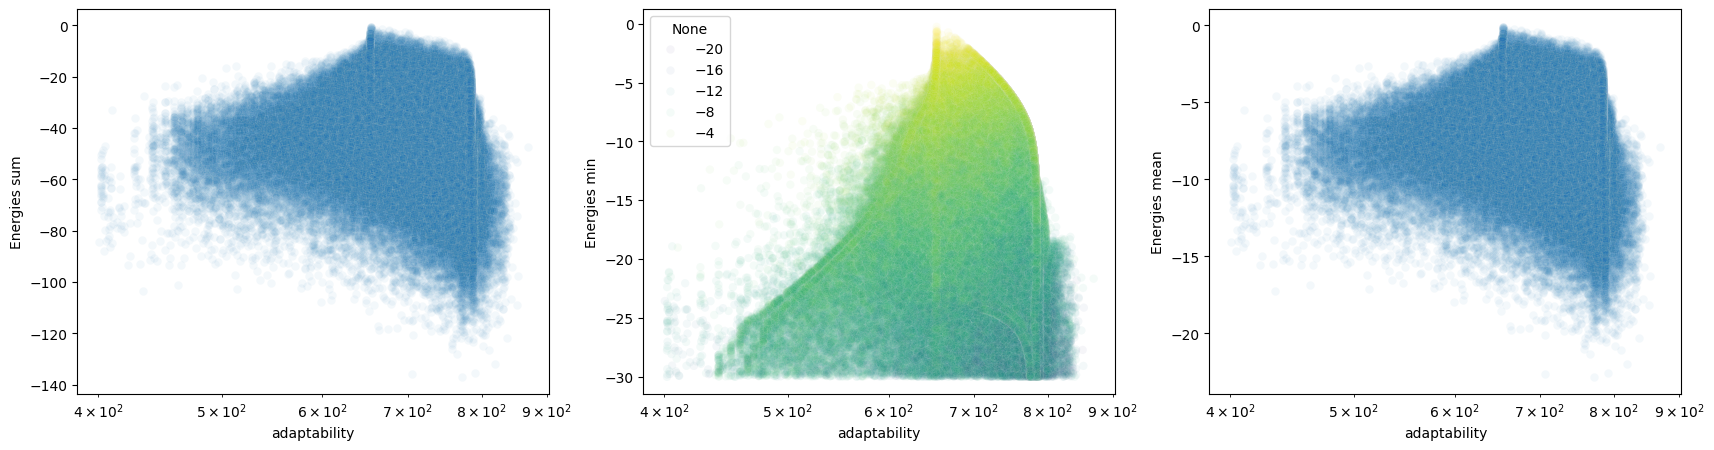

In [8]:
plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].sum(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies sum')
ax = plt.subplot(1,4,2)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].min(axis=1), alpha=0.05,
                hue=df[X_COLS].mean(axis=1), palette='viridis')
plt.xscale('log')
plt.ylabel('Energies min')
ax = plt.subplot(1,4,3)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].mean(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies mean')

### Reduce circuits that are overrepresented

In [9]:
df = df.reset_index(drop=True)

n_same_circ_max = 100
nbin = 500
agg_func = lambda x: np.sum(x, axis=1)
agg_func = lambda x: tuple(x)

df.loc[:, X_COLS] = df[X_COLS].apply(lambda x: np.round(x, 1))
df_bal = balance_dataset(df, cols=X_COLS, nbin=nbin, 
                         bin_max=n_same_circ_max, use_log=False, func1=agg_func)
df_bal = df_bal.reset_index(drop=True)


Text(0.5, 1.0, 'Adaptability after balancing')

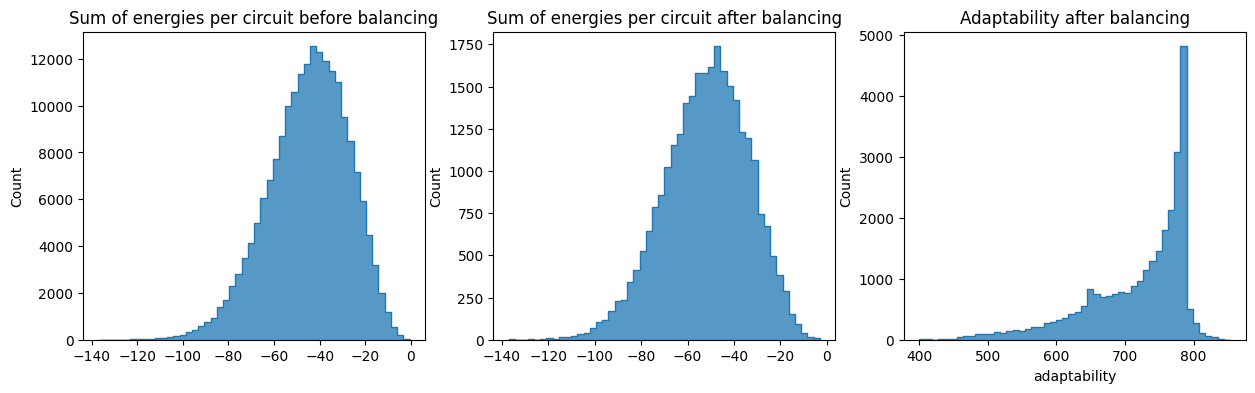

In [10]:
fig = plt.figure(figsize=(5*3, 4))
ax = plt.subplot(1,3,1)
sns.histplot(df[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit before balancing')
# ylim = ax.get_ylim()
ax = plt.subplot(1,3,2)
sns.histplot(df_bal[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit after balancing')
# plt.ylim(ylim)
ax = plt.subplot(1,3,3)
sns.histplot(df_bal, x='adaptability', bins=50, log_scale=[False, False], element='step')
plt.title('Adaptability after balancing')


Text(0.5, 0.98, 'Energies of species in a peak adaptability range')

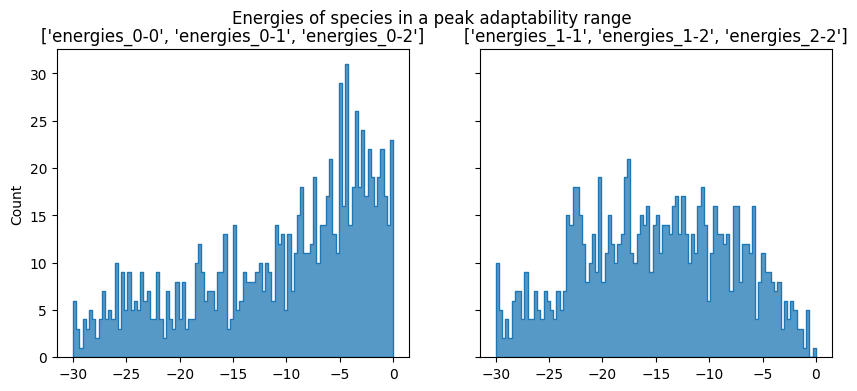

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

sns.histplot(df_bal[df_bal['adaptability'].between(650, 660)][X_COLS[:3]].min(axis=1), bins=100, element='step',
             ax=axs[0], log_scale=[False, False])
axs[0].set_title(X_COLS[:3])
sns.histplot(df_bal[df_bal['adaptability'].between(650, 660)][X_COLS[3:]].min(axis=1), bins=100, element='step',
             ax=axs[1], log_scale=[False, False])
axs[1].set_title(X_COLS[3:])
plt.suptitle('Energies of species in a peak adaptability range')

### Reduce the number of null circuits

In [12]:
# n_null_max = 100
# idxs_null = df[df[X_COLS].sum(axis=1) == 0].index

# df_bal2 = rem_idxs(df, np.random.choice(idxs_null, len(idxs_null) - n_null_max, replace=False))


# fig = plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.histplot(df[X_COLS].sum(axis=1), bins=50, element='step')
# plt.title('Before')
# plt.xlabel('Sum of interactions')
# ax = plt.subplot(1,2,2)
# plt.title('After')
# plt.xlabel('Sum of interactions')
# sns.histplot(df_bal2[X_COLS].sum(axis=1), bins=50, element='step')
# plt.suptitle('Balancing null circuits')


In [13]:
# bin_max = int(np.power(10, 3))
# nbin = 50
# func1 = lambda x: np.sum(x, axis=1)
# # df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# fig = plt.figure(figsize=(10,4))
# ax = plt.subplot(1,2,1)
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.title('Before')

# # Need to recurse this subsampling to make it neat
# for i in range(20):
#     df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# ax = plt.subplot(1,2,2)
# plt.title('After')
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.suptitle('Balancing energies + adaptability')

Text(0.5, 0.98, 'Balance of dataset for conditioning variable adaptability')

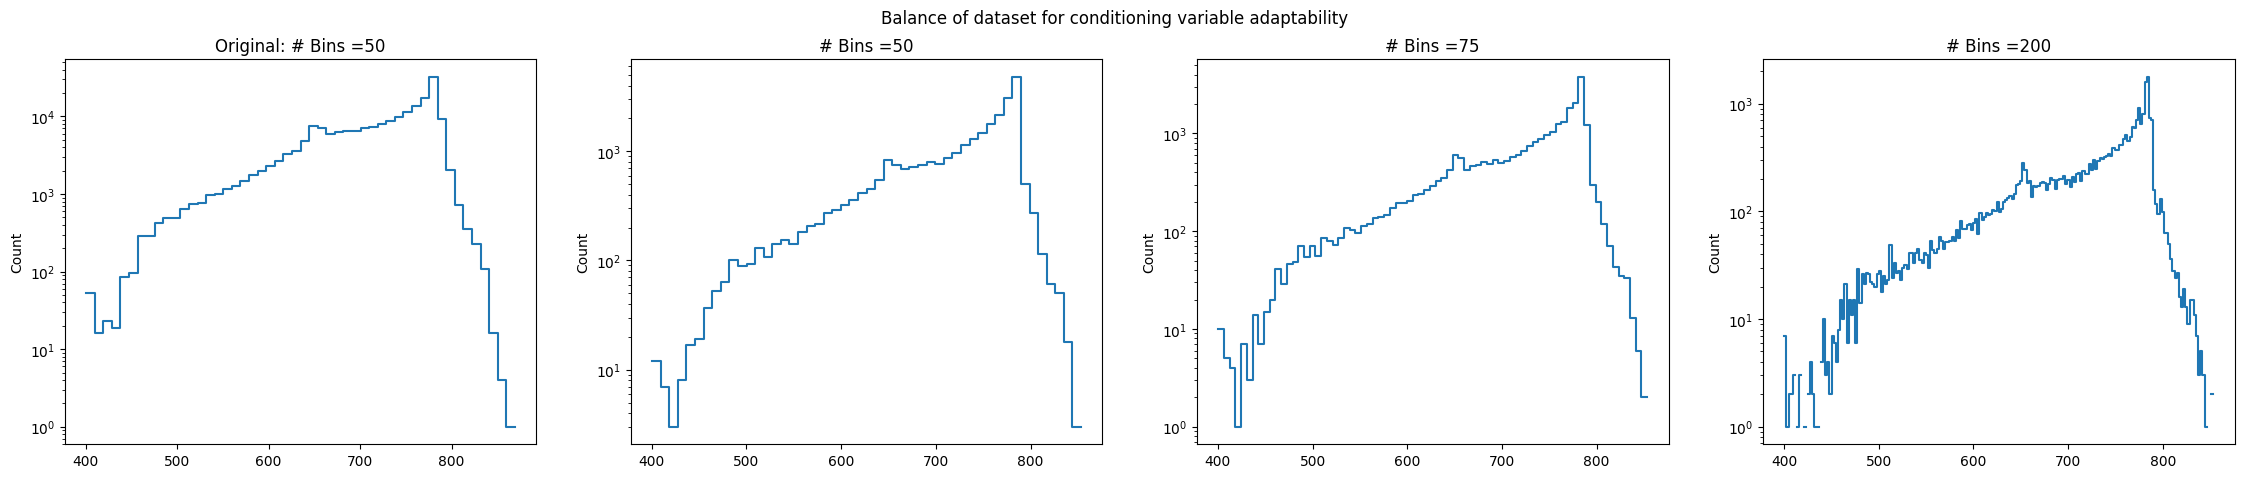

In [14]:
# Balance by bins
nbin = 50
bin_max = int(np.power(10, 4))
# df_bal = balance_dataset(df_bal, cols=OBJECTIVE_COL, nbin=nbin, bin_max=bin_max, use_log=False)
# df_bal = balance_dataset(df, cols=X_COLS, nbin=300, bin_max=bin_max, use_log=False, func1=lambda x: np.sum(x, axis=1))

fig = plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.histplot(df[OBJECTIVE_COL].to_numpy().flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Original: # Bins =' + str(50))
ax = plt.subplot(1,4,2)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin))
ax = plt.subplot(1,4,3)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=int(nbin*1.5), log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(int(nbin*1.5)))
ax = plt.subplot(1,4,4)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin*4, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin*4))

plt.suptitle('Balance of dataset for conditioning variable ' + str(OBJECTIVE_COL))


In [15]:
TOTAL_DS = int(np.min([TOTAL_DS, TOTAL_DS_MAX, len(df_bal)]))
TOTAL_DS = int(TOTAL_DS // BATCH_SIZE * BATCH_SIZE)
N_BATCHES = int(TOTAL_DS // BATCH_SIZE)

### Scale the input data

In [16]:
def apply_fns(x, fns):
    for fn in fns:
        x = fn(x)
    return x


def f_reshape(i): return i.reshape(N_BATCHES, BATCH_SIZE, i.shape[-1])
def f_unreshape(i): return i.reshape(np.prod(i.shape[:-1]), i.shape[-1])

In [17]:
x = [df_bal[i].iloc[:TOTAL_DS].values[:, None] for i in X_COLS]
x = np.concatenate(x, axis=1).squeeze()

x_scaling, x_unscaling = [], []
if USE_X_NEG:
    x_scaling.append(lambda x: -x)
    x_unscaling.append(lambda x: -x)
    x = x_scaling[-1](x)

if USE_X_LOGSCALE:
    x_scaling.append(np.log10)
    x_unscaling.append(lambda x: np.power(10, x))
    x = x_scaling[-1](x)

if SCALE_X_MINMAX:
    xscaler = MinMaxScaler().fit(x)
    # xscaler.fit(x)
    x_scaling.append(xscaler.transform)
    x_unscaling.append(xscaler.inverse_transform)
    x = x_scaling[-1](x)


x_unscaling = x_unscaling[::-1]


### Conditioning variable: target function

In [18]:
cond = df_bal[OBJECTIVE_COL].iloc[:TOTAL_DS].to_numpy()[:, None]

y_scaling, y_unscaling = [], []

if USE_Y_CATEGORICAL:

    vectorized_convert_to_scientific_exponent = np.vectorize(
        convert_to_scientific_exponent)
    numerical_resolution = 2
    cond_map = {k: numerical_resolution for k in np.arange(int(f'{cond[cond != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{cond.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    cond_map[-6] = 1
    cond_map[-5] = 1
    cond_map[-4] = 4
    cond_map[-3] = 2
    cond_map[-1] = 3
    cond = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=cond_map), cond)
    cond = np.interp(cond, sorted(np.unique(cond)), np.arange(
        len(sorted(np.unique(cond))))).astype(int)
    cond = y_scaling[-1](cond)

if USE_Y_LOGSCALE:
    zero_log_replacement = -10.0
    cond = np.where(cond != 0, np.log10(cond), zero_log_replacement)
    y_scaling.append(lambda x: np.where(x != 0, np.log10(x), zero_log_replacement))
    y_unscaling.append(lambda x: np.where(x != zero_log_replacement, np.power(10, x), 0))
    cond = y_scaling[-1](cond)
    
if SCALE_Y_MINMAX:
    yscaler = MinMaxScaler().fit(cond)
    y_scaling.append(yscaler.transform)
    y_unscaling.append(yscaler.inverse_transform)
    cond = y_scaling[-1](cond)


y_unscaling = y_unscaling[::-1]

In [19]:
N_HEAD = x.shape[-1]

x, cond = shuffle(x, cond, random_state=SEED)

if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [20]:
cond.shape, x.shape, np.concatenate([x, cond], axis=-1).shape

((28288, 1), (28288, 6), (28288, 7))

Text(0.5, 0.98, 'Dataset after balancing')

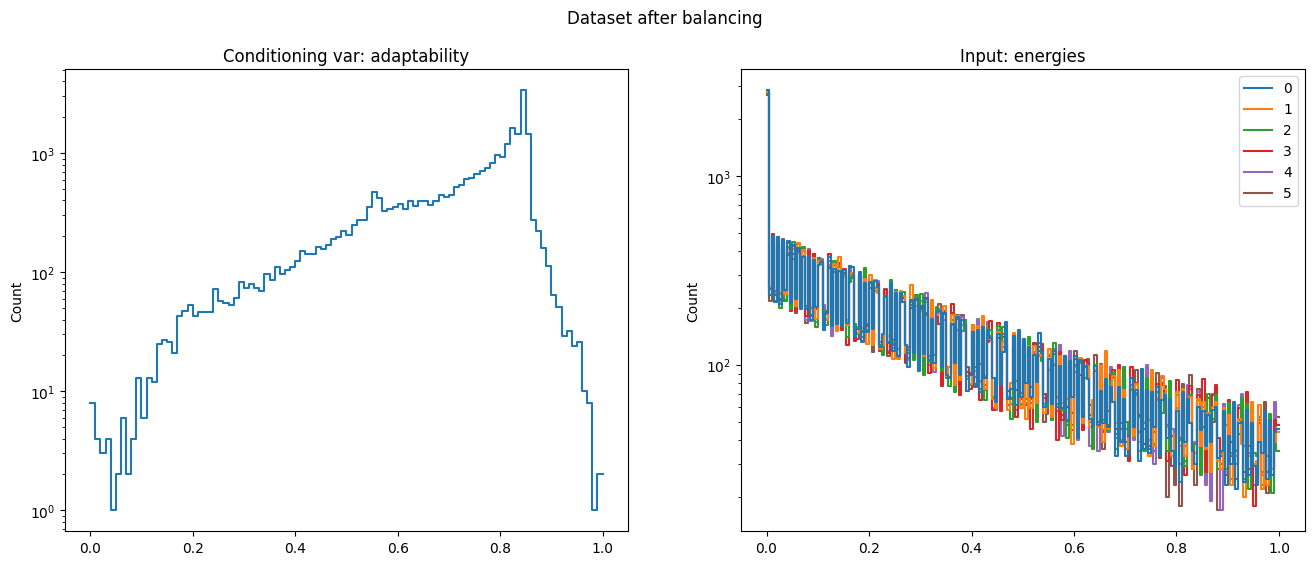

In [21]:
fig = plt.figure(figsize=(2*8, 6))

ax = plt.subplot(1,2,1)
sns.histplot(cond.flatten(), log_scale=[False, True], bins=100, element='step', fill=False)
plt.title(f'Conditioning var: {OBJECTIVE_COL}')

ax = plt.subplot(1,2,2)
sns.histplot(x, element='step', fill=False, bins=200, log_scale=[False, True])
plt.title(f'Input: {X_TYPE}')

plt.suptitle('Dataset after balancing')

## Init model

In [22]:
model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, decoder_head=x.shape[-1], HIDDEN_SIZE=HIDDEN_SIZE, USE_SIGMOID_DECODER=USE_SIGMOID_DECODER)
# model = hk.transform(model_fn)
model_t = hk.multi_transform(model_fn)
params = model_t.init(PRNG, x, cond, deterministic=False)


/usr/local/lib/python3.11/dist-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(


/usr/local/lib/python3.11/dist-packages/haiku/_src/base.py:661: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


/usr/local/lib/python3.11/dist-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(


/usr/local/lib/python3.11/dist-packages/haiku/_src/base.py:661: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [23]:
encoder, decoder, model, h2mu, h2logvar, reparam = model_t.apply


In [24]:
h = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))

In [25]:
model(params, PRNG, x, cond, return_muvar=False).shape

(28288, 6)

<Axes: ylabel='Count'>

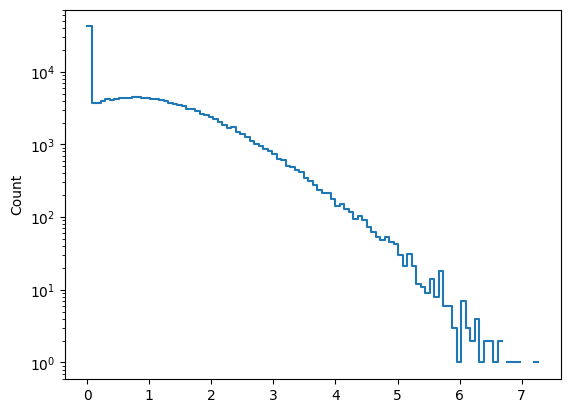

In [26]:
sns.histplot(model(params, PRNG, x, cond).flatten(), bins=100, log_scale=[False, True], element='step', fill=False)

## Init optimiser

In [27]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

# Train

In [28]:
x = f_reshape(x)
y = f_reshape(x)
cond = f_reshape(cond)
x_scaling.append(f_reshape)
x_unscaling.insert(0, f_unreshape)
y_scaling.append(f_reshape)
y_unscaling.insert(0, f_unreshape)


x_train, cond_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], cond[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, cond_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], cond[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]

x_train.shape

(176, 128, 6)

In [29]:
np.prod(x_train.shape[:2]), np.prod(x_val.shape[:2])


(np.int64(22528), np.int64(5760))

In [30]:
def train_step(params, x, y, cond, optimiser_state, model, rng, use_l2_reg, l2_reg_alpha, optimiser, loss_fn):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, optimiser_state, loss, grads


def eval_step(params, rng, model, x, y, cond, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy):
    """ Return the average of loss and accuracy on validation data """
    loss = loss_fn(params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)
    pred_y = model(params, rng, x, cond=cond)
    acc = compute_accuracy(pred_y, y)
    return acc, loss


def run_batches(params, model, rng,
                x_batch, y_batch, cond_batch,
                use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn):

    f_train_step = partial(train_step, model=model, rng=rng,
                           use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, optimiser=optimiser,
                           loss_fn=loss_fn)

    def f(carry, inp):

        params, optimiser_state = carry[0], carry[1]
        x_batch, y_batch, cond_batch = inp[0], inp[1], inp[2]

        params, optimiser_state, loss, grads = f_train_step(
            params, x_batch, y_batch, cond_batch, optimiser_state)
        return (params, optimiser_state), (loss, grads)

    # for x_batch, y_batch in xy_train:
    (params, optimiser_state), (train_loss, grads) = jax.lax.scan(
        f, (params, optimiser_state), (x_batch, y_batch, cond_batch))
    return params, optimiser_state, train_loss, grads


def train(params, rng, model,
          x_train, cond_train, y_train, x_val, cond_val, y_val,
          optimiser, optimiser_state,
          use_l2_reg, l2_reg_alpha, epochs,
          loss_fn, compute_accuracy,
          save_every, include_params_in_saves):

    def f(carry, _):
        params, optimiser_state = carry[0], carry[1]

        params, optimiser_state, train_loss, grads = run_batches(
            params, model, rng, x_train, y_train, cond_train, use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, cond_val, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy)

        return (params, optimiser_state), (params, grads, train_loss, val_loss, val_acc)

    saves = {}
    for e in range(epochs):
        (params, optimiser_state), (params_stack, grads, train_loss,
                                    val_loss, val_acc) = f((params, optimiser_state), None)

        if np.mod(e, save_every) == 0:
            saves[e] = make_saves(
                train_loss, val_loss, val_acc, include_params_in_saves, params_stack, grads)
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {np.mean(train_loss)}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')

    saves[list(saves.keys())[-1]]['params'] = params
    return params, saves

<Axes: ylabel='Count'>

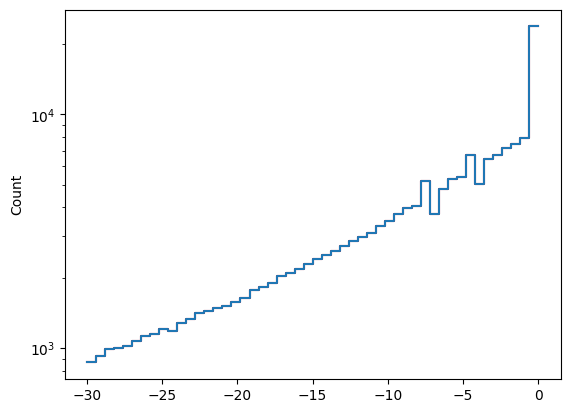

In [31]:
sns.histplot(np.concatenate([df_bal[i].iloc[:TOTAL_DS].values[:, None] for i in X_COLS], axis=1).squeeze().flatten(), bins=50, log_scale=[False, True], element='step', fill=False, color='r')
sns.histplot(apply_fns(x, x_unscaling).flatten(), bins=50, log_scale=[False, True], element='step', fill=False)


## Run train

In [32]:
tstart = datetime.now()
params, saves = train(params, PRNG, model, 
                      x_train, cond_train, y_train, x_val, cond_val, y_val, 
                      optimiser, optimiser_state,
                      use_l2_reg=USE_L2_REG, l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=accuracy_regression,
                      save_every=PRINT_EVERY, include_params_in_saves=False) 

print(datetime.now() - tstart)

Epoch 0 / 500 -		 Train loss: 1.0014965534210205	Val loss: 0.5675552487373352	Val accuracy: 0.18110531568527222


Epoch 5 / 500 -		 Train loss: 0.1466456949710846	Val loss: 0.16251471638679504	Val accuracy: 0.2925347089767456


Epoch 10 / 500 -		 Train loss: 0.1367397904396057	Val loss: 0.16511164605617523	Val accuracy: 0.28871527314186096


Epoch 15 / 500 -		 Train loss: 0.12571538984775543	Val loss: 0.16728012263774872	Val accuracy: 0.28382521867752075


Epoch 20 / 500 -		 Train loss: 0.11504713445901871	Val loss: 0.1666819006204605	Val accuracy: 0.2782696783542633


Epoch 25 / 500 -		 Train loss: 0.10166525840759277	Val loss: 0.16782818734645844	Val accuracy: 0.272251158952713


Epoch 30 / 500 -		 Train loss: 0.08919567614793777	Val loss: 0.16570329666137695	Val accuracy: 0.26987847685813904


Epoch 35 / 500 -		 Train loss: 0.07994040101766586	Val loss: 0.16294242441654205	Val accuracy: 0.2676793932914734


Epoch 40 / 500 -		 Train loss: 0.0712798610329628	Val loss: 0.15757201611995697	Val accuracy: 0.26814234256744385


Epoch 45 / 500 -		 Train loss: 0.0639142319560051	Val loss: 0.15036028623580933	Val accuracy: 0.27291667461395264


Epoch 50 / 500 -		 Train loss: 0.05750063434243202	Val loss: 0.1420586109161377	Val accuracy: 0.2779513895511627


Epoch 55 / 500 -		 Train loss: 0.0518709234893322	Val loss: 0.13284775614738464	Val accuracy: 0.2838541567325592


Epoch 60 / 500 -		 Train loss: 0.04692719876766205	Val loss: 0.12260235846042633	Val accuracy: 0.29169559478759766


Epoch 65 / 500 -		 Train loss: 0.04228513315320015	Val loss: 0.11140861362218857	Val accuracy: 0.3013888895511627


Epoch 70 / 500 -		 Train loss: 0.0377814881503582	Val loss: 0.09918736666440964	Val accuracy: 0.3133101761341095


Epoch 75 / 500 -		 Train loss: 0.033696580678224564	Val loss: 0.08666448295116425	Val accuracy: 0.3279513716697693


Epoch 80 / 500 -		 Train loss: 0.029903020709753036	Val loss: 0.07384397834539413	Val accuracy: 0.34707754850387573


Epoch 85 / 500 -		 Train loss: 0.026202604174613953	Val loss: 0.06034412980079651	Val accuracy: 0.3720775544643402


Epoch 90 / 500 -		 Train loss: 0.022361963987350464	Val loss: 0.04672764614224434	Val accuracy: 0.4108506739139557


Epoch 95 / 500 -		 Train loss: 0.018181132152676582	Val loss: 0.033580731600522995	Val accuracy: 0.4662615656852722


Epoch 100 / 500 -		 Train loss: 0.014016916044056416	Val loss: 0.022865474224090576	Val accuracy: 0.5409432649612427


Epoch 105 / 500 -		 Train loss: 0.010358867235481739	Val loss: 0.015118005685508251	Val accuracy: 0.6260416507720947


Epoch 110 / 500 -		 Train loss: 0.007600662764161825	Val loss: 0.010135120712220669	Val accuracy: 0.7155382037162781


Epoch 115 / 500 -		 Train loss: 0.005644690245389938	Val loss: 0.007056653965264559	Val accuracy: 0.7936632037162781


Epoch 120 / 500 -		 Train loss: 0.004295147955417633	Val loss: 0.005141626112163067	Val accuracy: 0.8564814925193787


Epoch 125 / 500 -		 Train loss: 0.003407425247132778	Val loss: 0.003954368177801371	Val accuracy: 0.8975694179534912


Epoch 130 / 500 -		 Train loss: 0.0028201770037412643	Val loss: 0.003198112826794386	Val accuracy: 0.9250578284263611


Epoch 135 / 500 -		 Train loss: 0.0024101869203150272	Val loss: 0.0026791116688400507	Val accuracy: 0.9432002305984497


Epoch 140 / 500 -		 Train loss: 0.00210609775967896	Val loss: 0.002311934716999531	Val accuracy: 0.9558448791503906


Epoch 145 / 500 -		 Train loss: 0.001873645931482315	Val loss: 0.002035716315731406	Val accuracy: 0.9663194417953491


Epoch 150 / 500 -		 Train loss: 0.0016914475709199905	Val loss: 0.0018239447381347418	Val accuracy: 0.9731191992759705


Epoch 155 / 500 -		 Train loss: 0.00154356868006289	Val loss: 0.0016582106472924352	Val accuracy: 0.9771701097488403


Epoch 160 / 500 -		 Train loss: 0.001420494168996811	Val loss: 0.0015256693586707115	Val accuracy: 0.9806134104728699


Epoch 165 / 500 -		 Train loss: 0.0013164919801056385	Val loss: 0.0014142801519483328	Val accuracy: 0.9835647940635681


Epoch 170 / 500 -		 Train loss: 0.0012297971406951547	Val loss: 0.0013247212627902627	Val accuracy: 0.9858796000480652


Epoch 175 / 500 -		 Train loss: 0.0011570825008675456	Val loss: 0.0012484838953241706	Val accuracy: 0.987442135810852


Epoch 180 / 500 -		 Train loss: 0.0010937867918983102	Val loss: 0.0011743538780137897	Val accuracy: 0.9885126948356628


Epoch 185 / 500 -		 Train loss: 0.001039130729623139	Val loss: 0.001121890963986516	Val accuracy: 0.9895833134651184


Epoch 190 / 500 -		 Train loss: 0.0009903977625072002	Val loss: 0.0010634280042722821	Val accuracy: 0.9905381798744202


Epoch 195 / 500 -		 Train loss: 0.000948427536059171	Val loss: 0.0010208503808826208	Val accuracy: 0.9913772940635681


Epoch 200 / 500 -		 Train loss: 0.0009101371397264302	Val loss: 0.0009800210827961564	Val accuracy: 0.9921006560325623


Epoch 205 / 500 -		 Train loss: 0.0008763772202655673	Val loss: 0.000940808211453259	Val accuracy: 0.9928240776062012


Epoch 210 / 500 -		 Train loss: 0.0008460878161713481	Val loss: 0.00091085972962901	Val accuracy: 0.9934606552124023


Epoch 215 / 500 -		 Train loss: 0.0008180392323993146	Val loss: 0.0008761579520069063	Val accuracy: 0.9942129254341125


Epoch 220 / 500 -		 Train loss: 0.0007919813506305218	Val loss: 0.0008565106545574963	Val accuracy: 0.994560182094574


Epoch 225 / 500 -		 Train loss: 0.0007682490395382047	Val loss: 0.0008282774942927063	Val accuracy: 0.9948495030403137


Epoch 230 / 500 -		 Train loss: 0.0007476966129615903	Val loss: 0.0008031451725400984	Val accuracy: 0.9951388835906982


Epoch 235 / 500 -		 Train loss: 0.0007274086819961667	Val loss: 0.0007801968604326248	Val accuracy: 0.9953703284263611


Epoch 240 / 500 -		 Train loss: 0.0007089160499162972	Val loss: 0.0007606497383676469	Val accuracy: 0.9956307411193848


Epoch 245 / 500 -		 Train loss: 0.0006918755825608969	Val loss: 0.0007386638899333775	Val accuracy: 0.9958912134170532


Epoch 250 / 500 -		 Train loss: 0.0006749759195372462	Val loss: 0.0007255852688103914	Val accuracy: 0.9960069060325623


Epoch 255 / 500 -		 Train loss: 0.0006609697011299431	Val loss: 0.0007105882395990193	Val accuracy: 0.9961516261100769


Epoch 260 / 500 -		 Train loss: 0.0006466938066296279	Val loss: 0.0006916830316185951	Val accuracy: 0.996180534362793


Epoch 265 / 500 -		 Train loss: 0.0006341841071844101	Val loss: 0.0006756410584785044	Val accuracy: 0.9962673187255859


Epoch 270 / 500 -		 Train loss: 0.0006223997916094959	Val loss: 0.0006638733320869505	Val accuracy: 0.9962962865829468


Epoch 275 / 500 -		 Train loss: 0.000610696617513895	Val loss: 0.0006528724916279316	Val accuracy: 0.9964409470558167


Epoch 280 / 500 -		 Train loss: 0.0006001599249430001	Val loss: 0.0006411148933693767	Val accuracy: 0.9964409470558167


Epoch 285 / 500 -		 Train loss: 0.0005903835408389568	Val loss: 0.0006267676362767816	Val accuracy: 0.9964699149131775


Epoch 290 / 500 -		 Train loss: 0.0005813518655486405	Val loss: 0.0006210387800820172	Val accuracy: 0.9966145753860474


Epoch 295 / 500 -		 Train loss: 0.000572045159060508	Val loss: 0.0006107297376729548	Val accuracy: 0.9967303276062012


Epoch 300 / 500 -		 Train loss: 0.0005639048176817596	Val loss: 0.0006007759366184473	Val accuracy: 0.9967303276062012


Epoch 305 / 500 -		 Train loss: 0.0005557659897021949	Val loss: 0.0005905227153562009	Val accuracy: 0.996874988079071


Epoch 310 / 500 -		 Train loss: 0.0005480268155224621	Val loss: 0.0005801683873869479	Val accuracy: 0.996961772441864


Epoch 315 / 500 -		 Train loss: 0.0005414904444478452	Val loss: 0.0005751718417741358	Val accuracy: 0.9970775246620178


Epoch 320 / 500 -		 Train loss: 0.0005344775854609907	Val loss: 0.0005657721194438636	Val accuracy: 0.9972511529922485


Epoch 325 / 500 -		 Train loss: 0.0005277378368191421	Val loss: 0.0005595730035565794	Val accuracy: 0.9971932768821716


Epoch 330 / 500 -		 Train loss: 0.0005218031001277268	Val loss: 0.0005543123697862029	Val accuracy: 0.9973090291023254


Epoch 335 / 500 -		 Train loss: 0.0005159888532944024	Val loss: 0.000544277485460043	Val accuracy: 0.9973090291023254


Epoch 340 / 500 -		 Train loss: 0.0005106476601213217	Val loss: 0.0005395830958150327	Val accuracy: 0.9974247217178345


Epoch 345 / 500 -		 Train loss: 0.0005059350514784455	Val loss: 0.0005334913730621338	Val accuracy: 0.9973669052124023


Epoch 350 / 500 -		 Train loss: 0.0005011458997614682	Val loss: 0.0005306917009875178	Val accuracy: 0.9974825978279114


Epoch 355 / 500 -		 Train loss: 0.0004962050588801503	Val loss: 0.0005271146656014025	Val accuracy: 0.9974825978279114


Epoch 360 / 500 -		 Train loss: 0.0004921533400192857	Val loss: 0.0005215153796598315	Val accuracy: 0.9974536895751953


Epoch 365 / 500 -		 Train loss: 0.0004878535692114383	Val loss: 0.0005161610897630453	Val accuracy: 0.9975983500480652


Epoch 370 / 500 -		 Train loss: 0.00048369771684519947	Val loss: 0.0005121349240653217	Val accuracy: 0.9975694417953491


Epoch 375 / 500 -		 Train loss: 0.0004799873277079314	Val loss: 0.0005064940196461976	Val accuracy: 0.9976562261581421


Epoch 380 / 500 -		 Train loss: 0.000476275832625106	Val loss: 0.0004999192897230387	Val accuracy: 0.997714102268219


Epoch 385 / 500 -		 Train loss: 0.0004728214698843658	Val loss: 0.0004965222906321287	Val accuracy: 0.9976851940155029


Epoch 390 / 500 -		 Train loss: 0.0004693846858572215	Val loss: 0.0004959598300047219	Val accuracy: 0.9977430105209351


Epoch 395 / 500 -		 Train loss: 0.0004665024462155998	Val loss: 0.0004944136599078774	Val accuracy: 0.997714102268219


Epoch 400 / 500 -		 Train loss: 0.00046366945025511086	Val loss: 0.000490537378937006	Val accuracy: 0.9977719783782959


Epoch 405 / 500 -		 Train loss: 0.0004605264402925968	Val loss: 0.0004862683708779514	Val accuracy: 0.9977719783782959


Epoch 410 / 500 -		 Train loss: 0.0004580827080644667	Val loss: 0.0004834225692320615	Val accuracy: 0.9977719783782959


Epoch 415 / 500 -		 Train loss: 0.00045580114237964153	Val loss: 0.0004824544594157487	Val accuracy: 0.997800886631012


Epoch 420 / 500 -		 Train loss: 0.000453147164080292	Val loss: 0.00047856359742581844	Val accuracy: 0.997800886631012


Epoch 425 / 500 -		 Train loss: 0.0004511571314651519	Val loss: 0.00047571316827088594	Val accuracy: 0.9978298544883728


Epoch 430 / 500 -		 Train loss: 0.00044884043745696545	Val loss: 0.00047579914098605514	Val accuracy: 0.9978877305984497


Epoch 435 / 500 -		 Train loss: 0.0004470902495086193	Val loss: 0.0004709019558504224	Val accuracy: 0.9979456067085266


Epoch 440 / 500 -		 Train loss: 0.00044532486936077476	Val loss: 0.0004701102152466774	Val accuracy: 0.9979456067085266


Epoch 445 / 500 -		 Train loss: 0.0004432512214407325	Val loss: 0.00046709785237908363	Val accuracy: 0.9979745149612427


Epoch 450 / 500 -		 Train loss: 0.0004416669544298202	Val loss: 0.0004653915821108967	Val accuracy: 0.9979456067085266


Epoch 455 / 500 -		 Train loss: 0.00043996068416163325	Val loss: 0.0004646813322324306	Val accuracy: 0.9979456067085266


Epoch 460 / 500 -		 Train loss: 0.0004386407963465899	Val loss: 0.0004606234433595091	Val accuracy: 0.9979456067085266


Epoch 465 / 500 -		 Train loss: 0.0004372410476207733	Val loss: 0.0004608752205967903	Val accuracy: 0.9980034828186035


Epoch 470 / 500 -		 Train loss: 0.0004359281447250396	Val loss: 0.00046085799112915993	Val accuracy: 0.9979745149612427


Epoch 475 / 500 -		 Train loss: 0.0004348295333329588	Val loss: 0.0004609982715919614	Val accuracy: 0.9979745149612427


Epoch 480 / 500 -		 Train loss: 0.0004335492558311671	Val loss: 0.00045888934982940555	Val accuracy: 0.9980034828186035


Epoch 485 / 500 -		 Train loss: 0.00043270463356748223	Val loss: 0.0004576674255076796	Val accuracy: 0.9981191754341125


Epoch 490 / 500 -		 Train loss: 0.00043157319305464625	Val loss: 0.0004541259550023824	Val accuracy: 0.9980902671813965


Epoch 495 / 500 -		 Train loss: 0.0004306460323277861	Val loss: 0.0004535867483355105	Val accuracy: 0.9980323910713196


0:07:12.355649


# Visualise

Text(0.5, 0.98, 'Training')

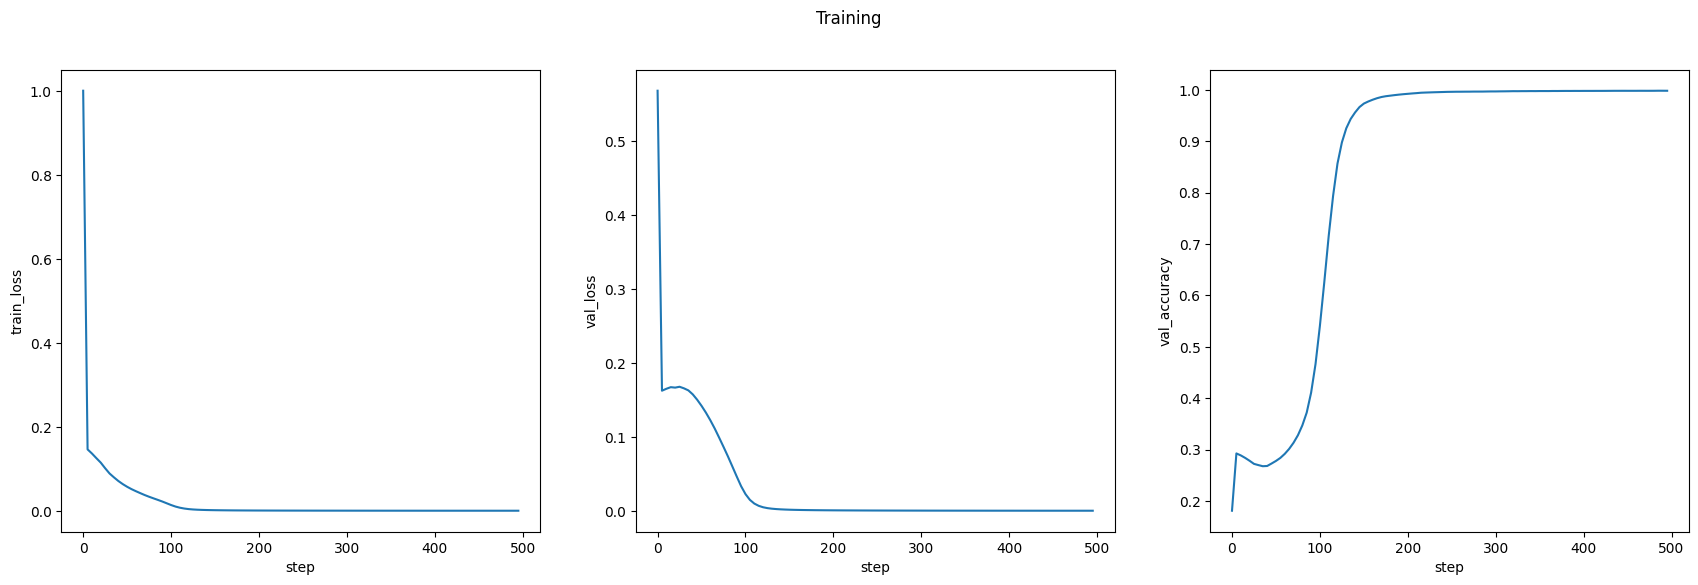

In [33]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.suptitle('Training')

In [34]:
write_json(saves, out_path=save_path)

In [35]:
print(save_path)

weight_saves/01_cvae/2024_12_08__21_21_04_saves_no_KL


# Examine trained model

In [36]:
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__15_01_35_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__16_58_36_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_28__14_12_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_29__10_43_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_02__13_49_00_saves_test')  # sensitivity
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__14_54_23_saves_test')  # generated from interactions
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__17_57_39_saves_test')  # generated from interactions with sigmoid in decoder for 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__17_45_52_saves_no_sigmoid_decoder')  # generated from interactions with sigmoid in decoder for 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__18_59_40_saves_KL_div')  # generated from interactions + sigmoid + KL divergence
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__20_55_42_saves_no_KL')  # generated from interactions + sigmoid
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(221, 128, 6)

Text(0.5, 0, 'step')

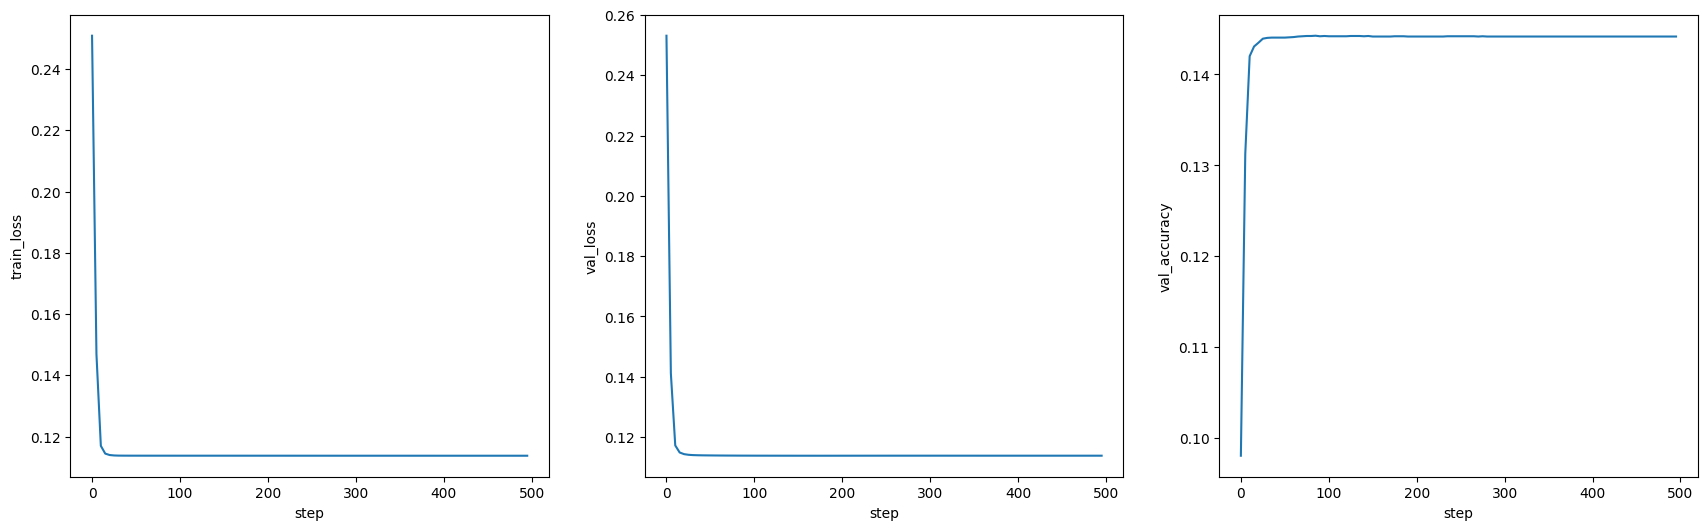

In [37]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['train_loss']) for v in saves_loaded.values()]))
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_loss']) for v in saves_loaded.values()]))
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_accuracy']) for v in saves_loaded.values()]))
plt.ylabel('val_accuracy')
plt.xlabel('step')

The R2 score is  -1.2052904202552206
The R2 score with weighted variance is  -1.2052904202552206


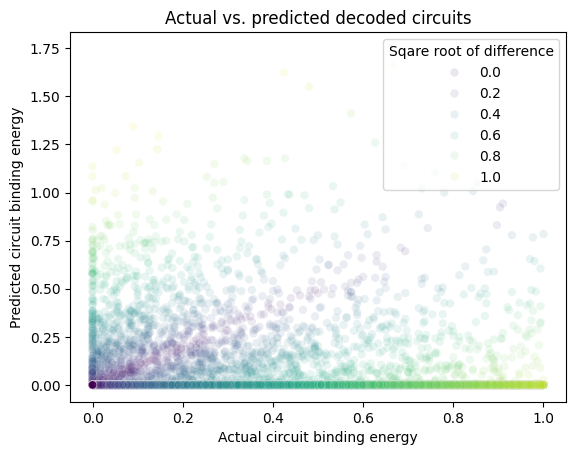

In [38]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

# Sample fake circuits

In [39]:
n_to_sample = 10000

sampled_cond = np.interp(np.random.rand(n_to_sample, cond.shape[-1]), [0, 1], [cond.min(), cond.max()])
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 5000
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 100
z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10000, 1)

Text(0.5, 0.98, 'Interactions for CVAE: 10000 circuits')

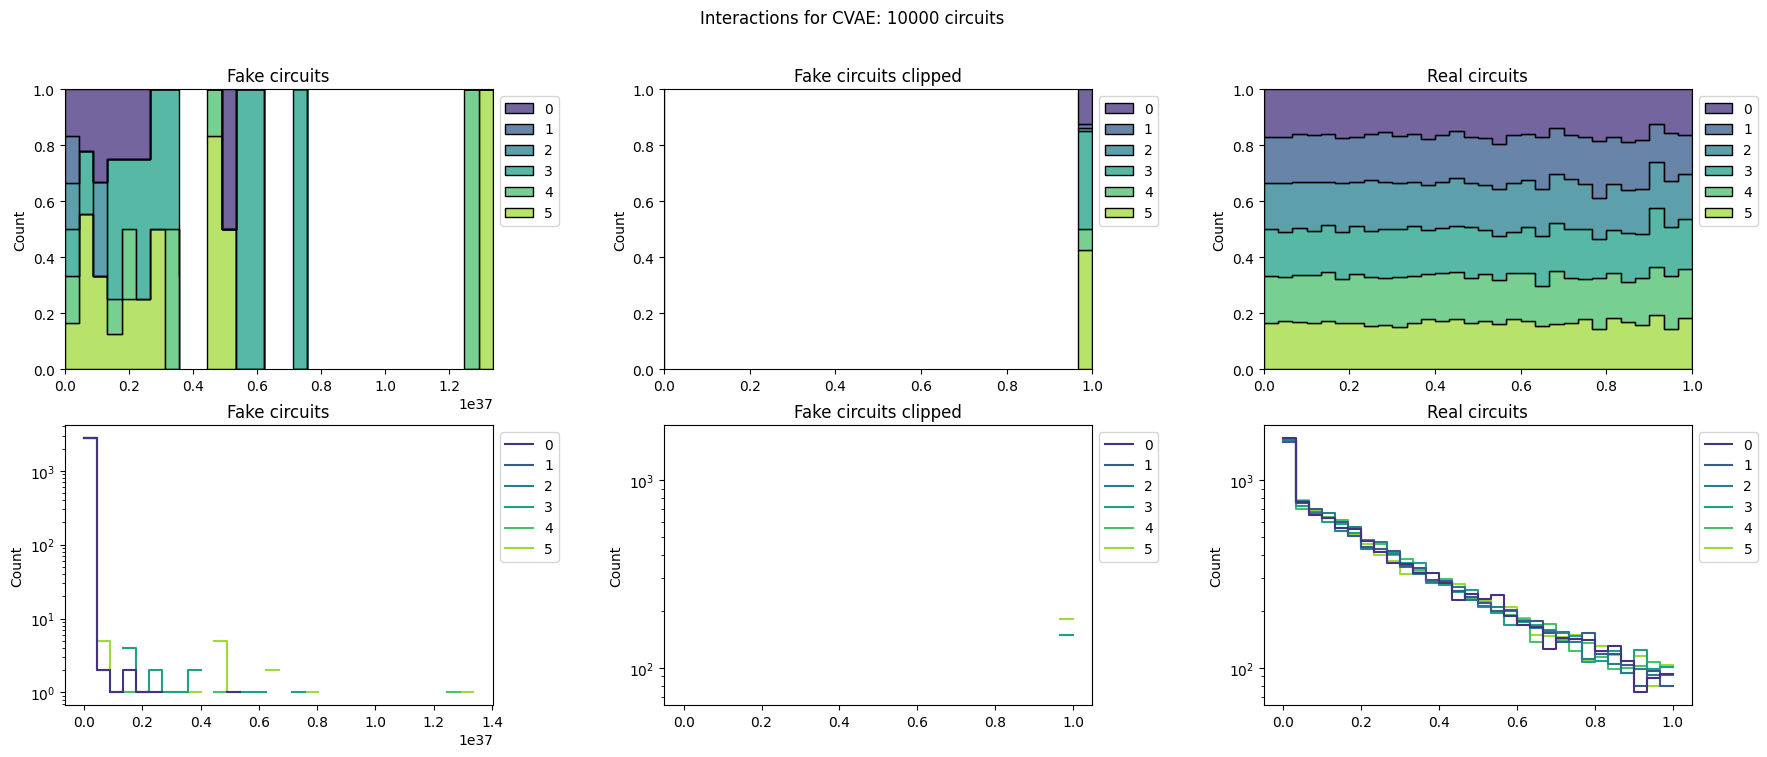

In [40]:
fig = plt.figure(figsize=(7*3, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2, 3, 1)
g = sns.histplot(fake_circuits, element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 2)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 3)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample],
                 element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Real circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 4)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 5)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 6)
x_hist = x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample]
g2 = sns.histplot(x_hist, element='step', bins=30, palette='viridis',
                  multiple='layer', fill=False, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'Interactions for CVAE: {n_to_sample} circuits')

Text(0.5, 0.98, 'CVAE: 2000 circuits')

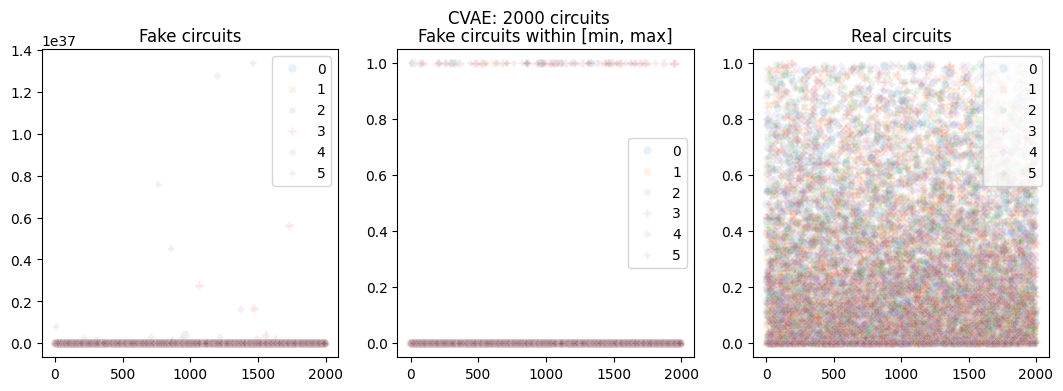

In [41]:
fig = plt.figure(figsize=(13, 4))

show_max = 2000

ax = plt.subplot(1, 3, 1)
sns.scatterplot(fake_circuits[:show_max], alpha=0.1)
plt.title('Fake circuits')

ax = plt.subplot(1, 3, 2)
fake_circuits_1 = np.where(fake_circuits[:show_max] > x.max(), x.max(), fake_circuits[:show_max])
sns.scatterplot(np.where(fake_circuits_1 < x.min(), x.min(), fake_circuits_1), alpha=0.1)
plt.title('Fake circuits within [min, max]')

ax = plt.subplot(1, 3, 3)
sns.scatterplot(
    x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max], alpha=0.1)
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')

## Conditionality

In [42]:
n_categories = 5
n_to_sample = 10000

sampled_cond = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 1
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 2
z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = np.repeat(z[None, :], repeats=n_categories, axis=0)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(x=z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)

Text(0.5, 0.98, 'CVAE: fake circuits')

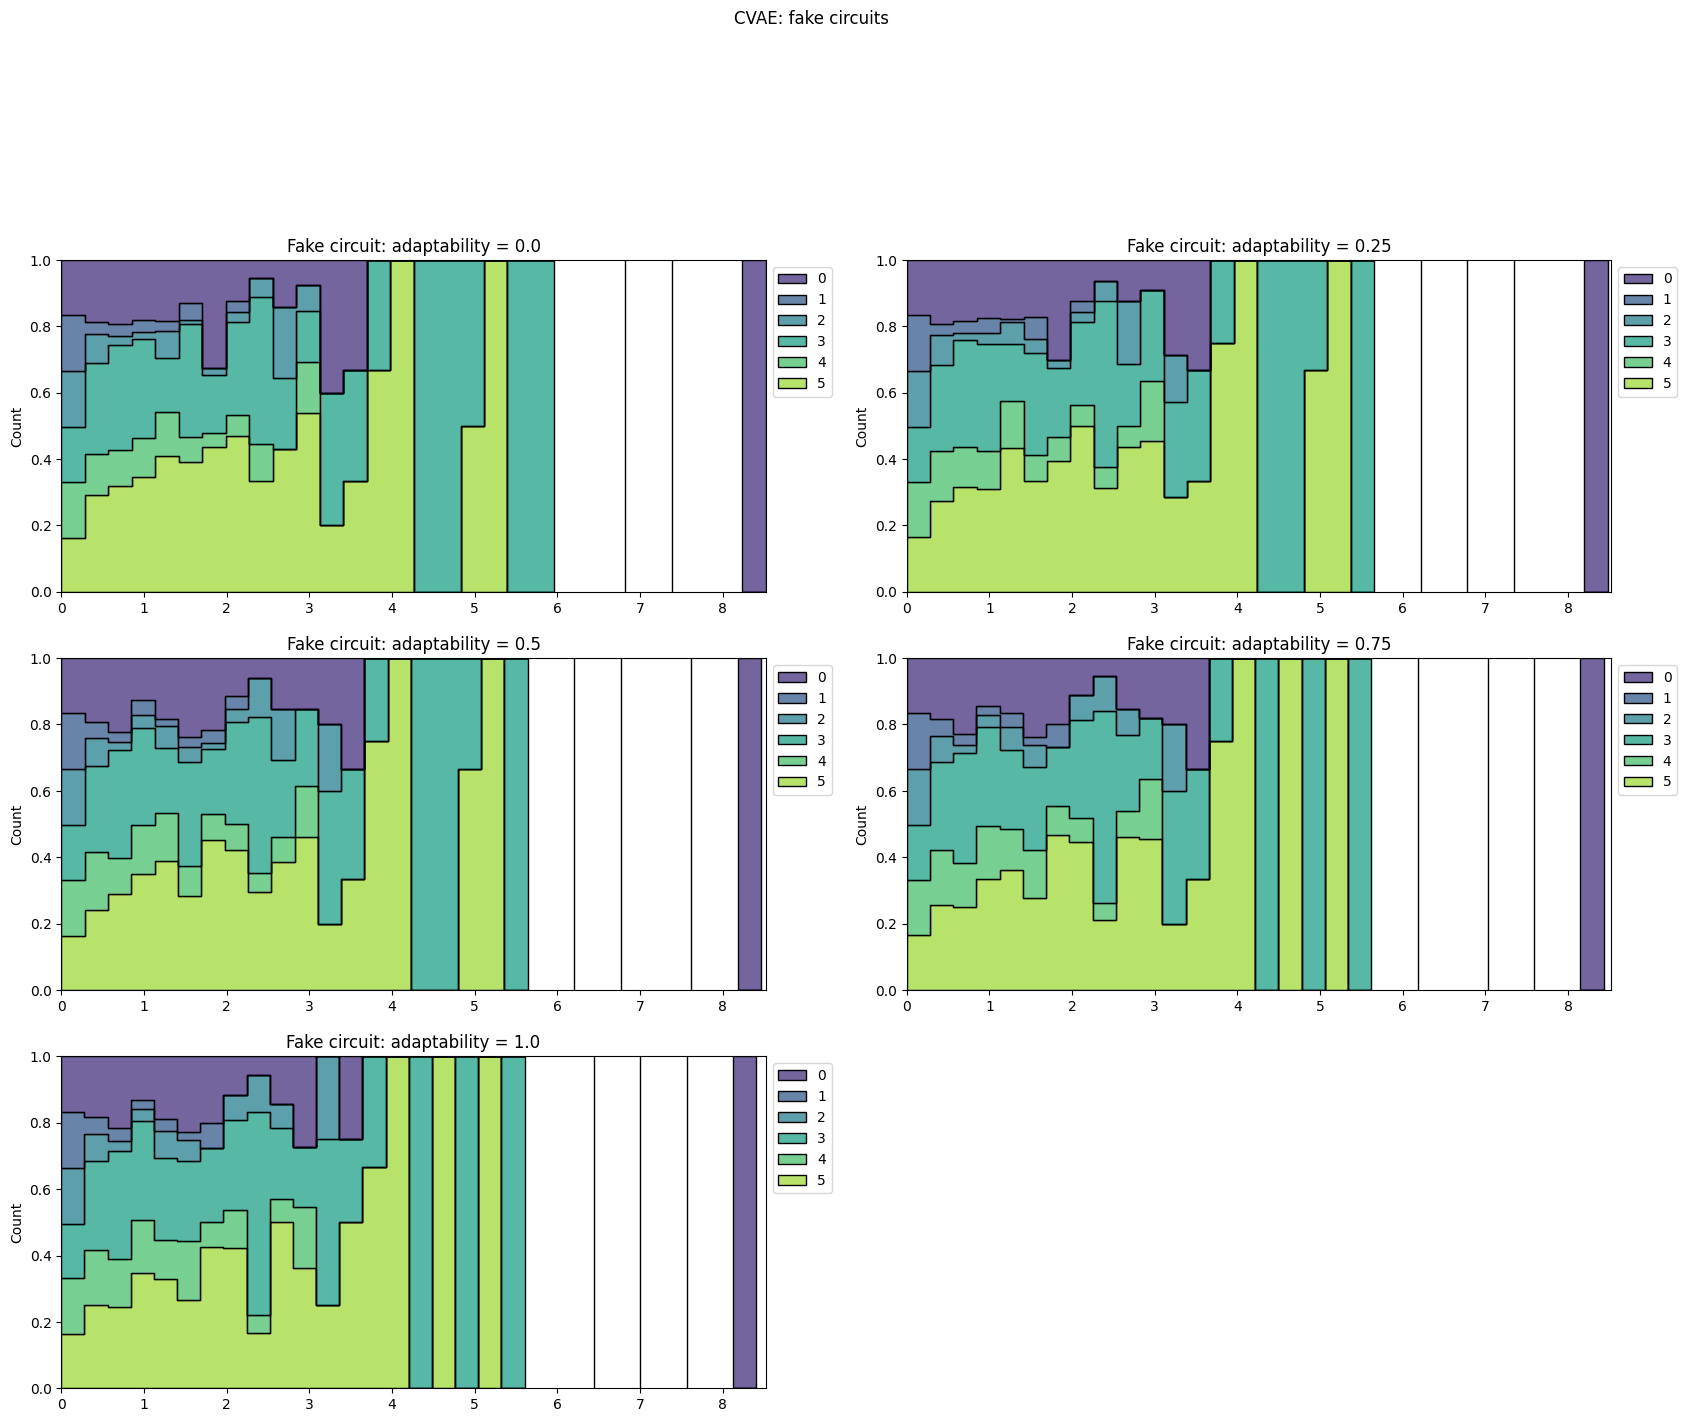

In [43]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, (zi, cat) in enumerate(zip(z, fake_circuits)):
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'Fake circuit: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: fake circuits')

## Compare to real circuit's objective

In [44]:
def round_to_nearest_array(x, y):
    """ 
    x: array to be mapped over
    y: array with integers to round to """
    distances = np.abs(x[:, None] - y[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    nearest_values = y[nearest_indices]
    return nearest_values


def bin_to_nearest_edge(x: np.ndarray, n_bins):
    """ Bin the elements in x to the nearest lowest bin """
    edges = np.linspace(x.min(), x.max(), n_bins)
    return round_to_nearest_array(x, edges)


def apply_fns(x, fns: list):
    og_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(*(np.prod(x.shape[:-1]), x.shape[-1]))
    for fcn in fns:
        x = fcn(x)
    return x.reshape(og_shape)

# df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(np.log10(df[OBJECTIVE_COL].to_numpy()), n_bins=n_categories)
# y_obj_all = df[OBJECTIVE_COL].to_numpy()
# for y_scale in y_scaling:
#     y_obj_all = y_scale(y_obj_all)
# df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(y_obj_all, n_bins=n_categories)
df = df[~df[OBJECTIVE_COL].isna()]
df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(df[OBJECTIVE_COL].to_numpy(), n_bins=n_categories)
fake_circuits = apply_fns(fake_circuits, fns = x_unscaling)


In [45]:
fake_circuits = np.where(fake_circuits > df[X_COLS[0]].max().max(), df[X_COLS[0]].max().max(), fake_circuits)

Text(0.5, 0.98, 'CVAE: real circuits')

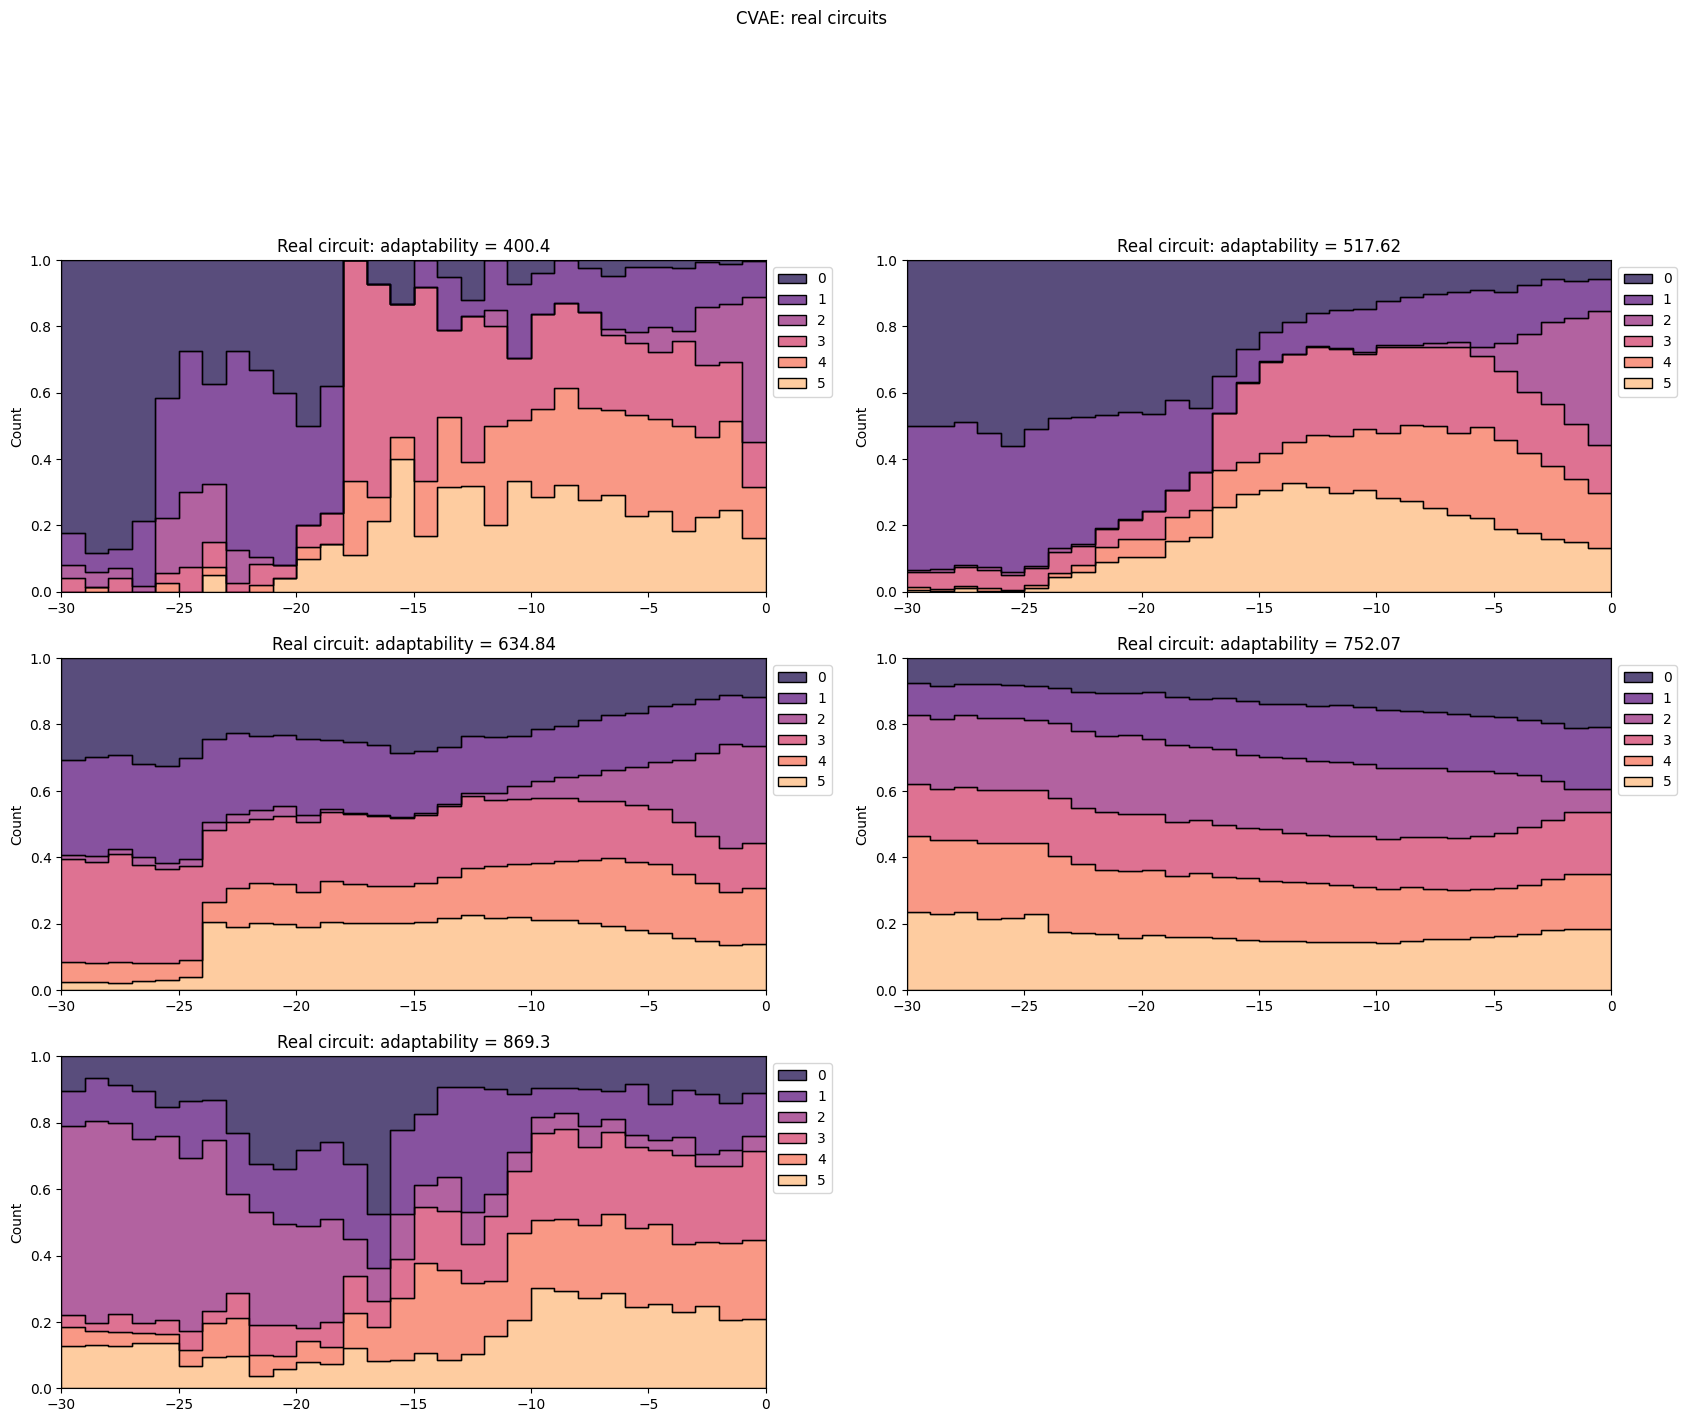

In [46]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, edge in enumerate(sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique())):
    cat = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge]
    cat = cat[X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='magma', multiple='fill')
    plt.title(f'Real circuit: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: real circuits')

### Combined

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

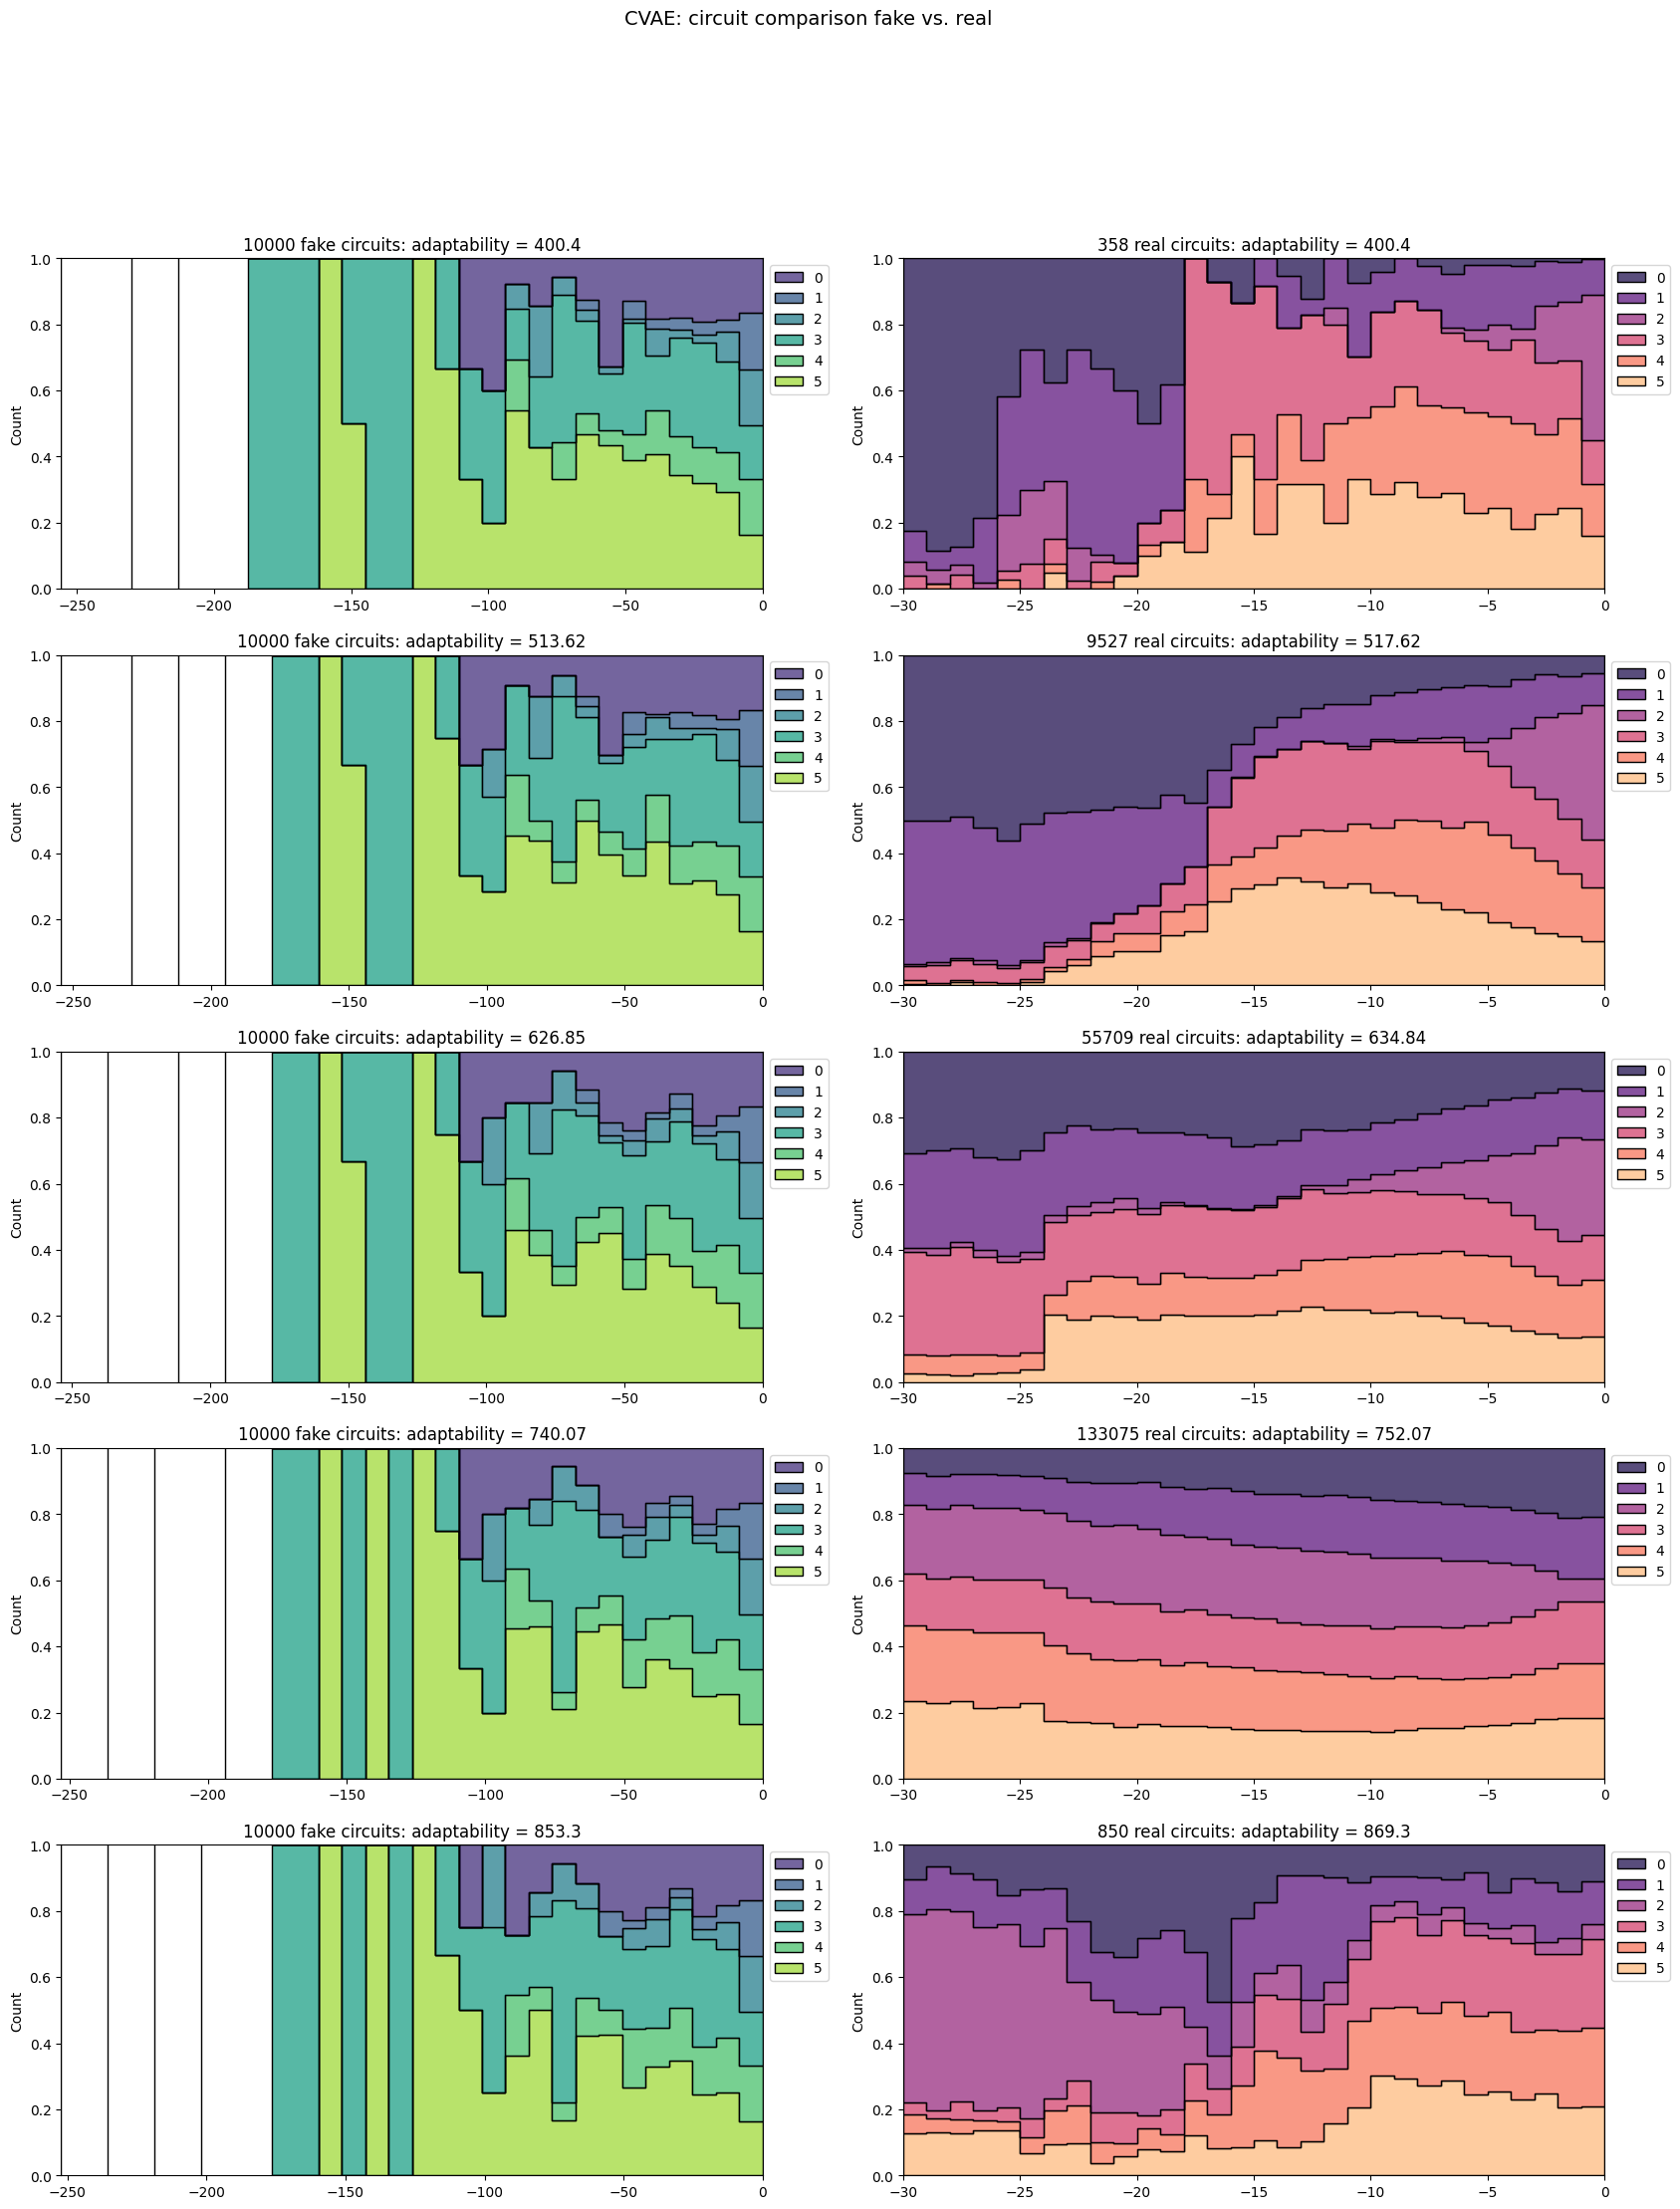

In [47]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    widest_lim = [0, 0]
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill')
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    for y_unscale in y_unscaling:
        sc = y_unscale(sc)
    plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(5, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='fill')
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
    # g1.set_xlim(widest_lim)
    # g2.set_xlim(widest_lim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

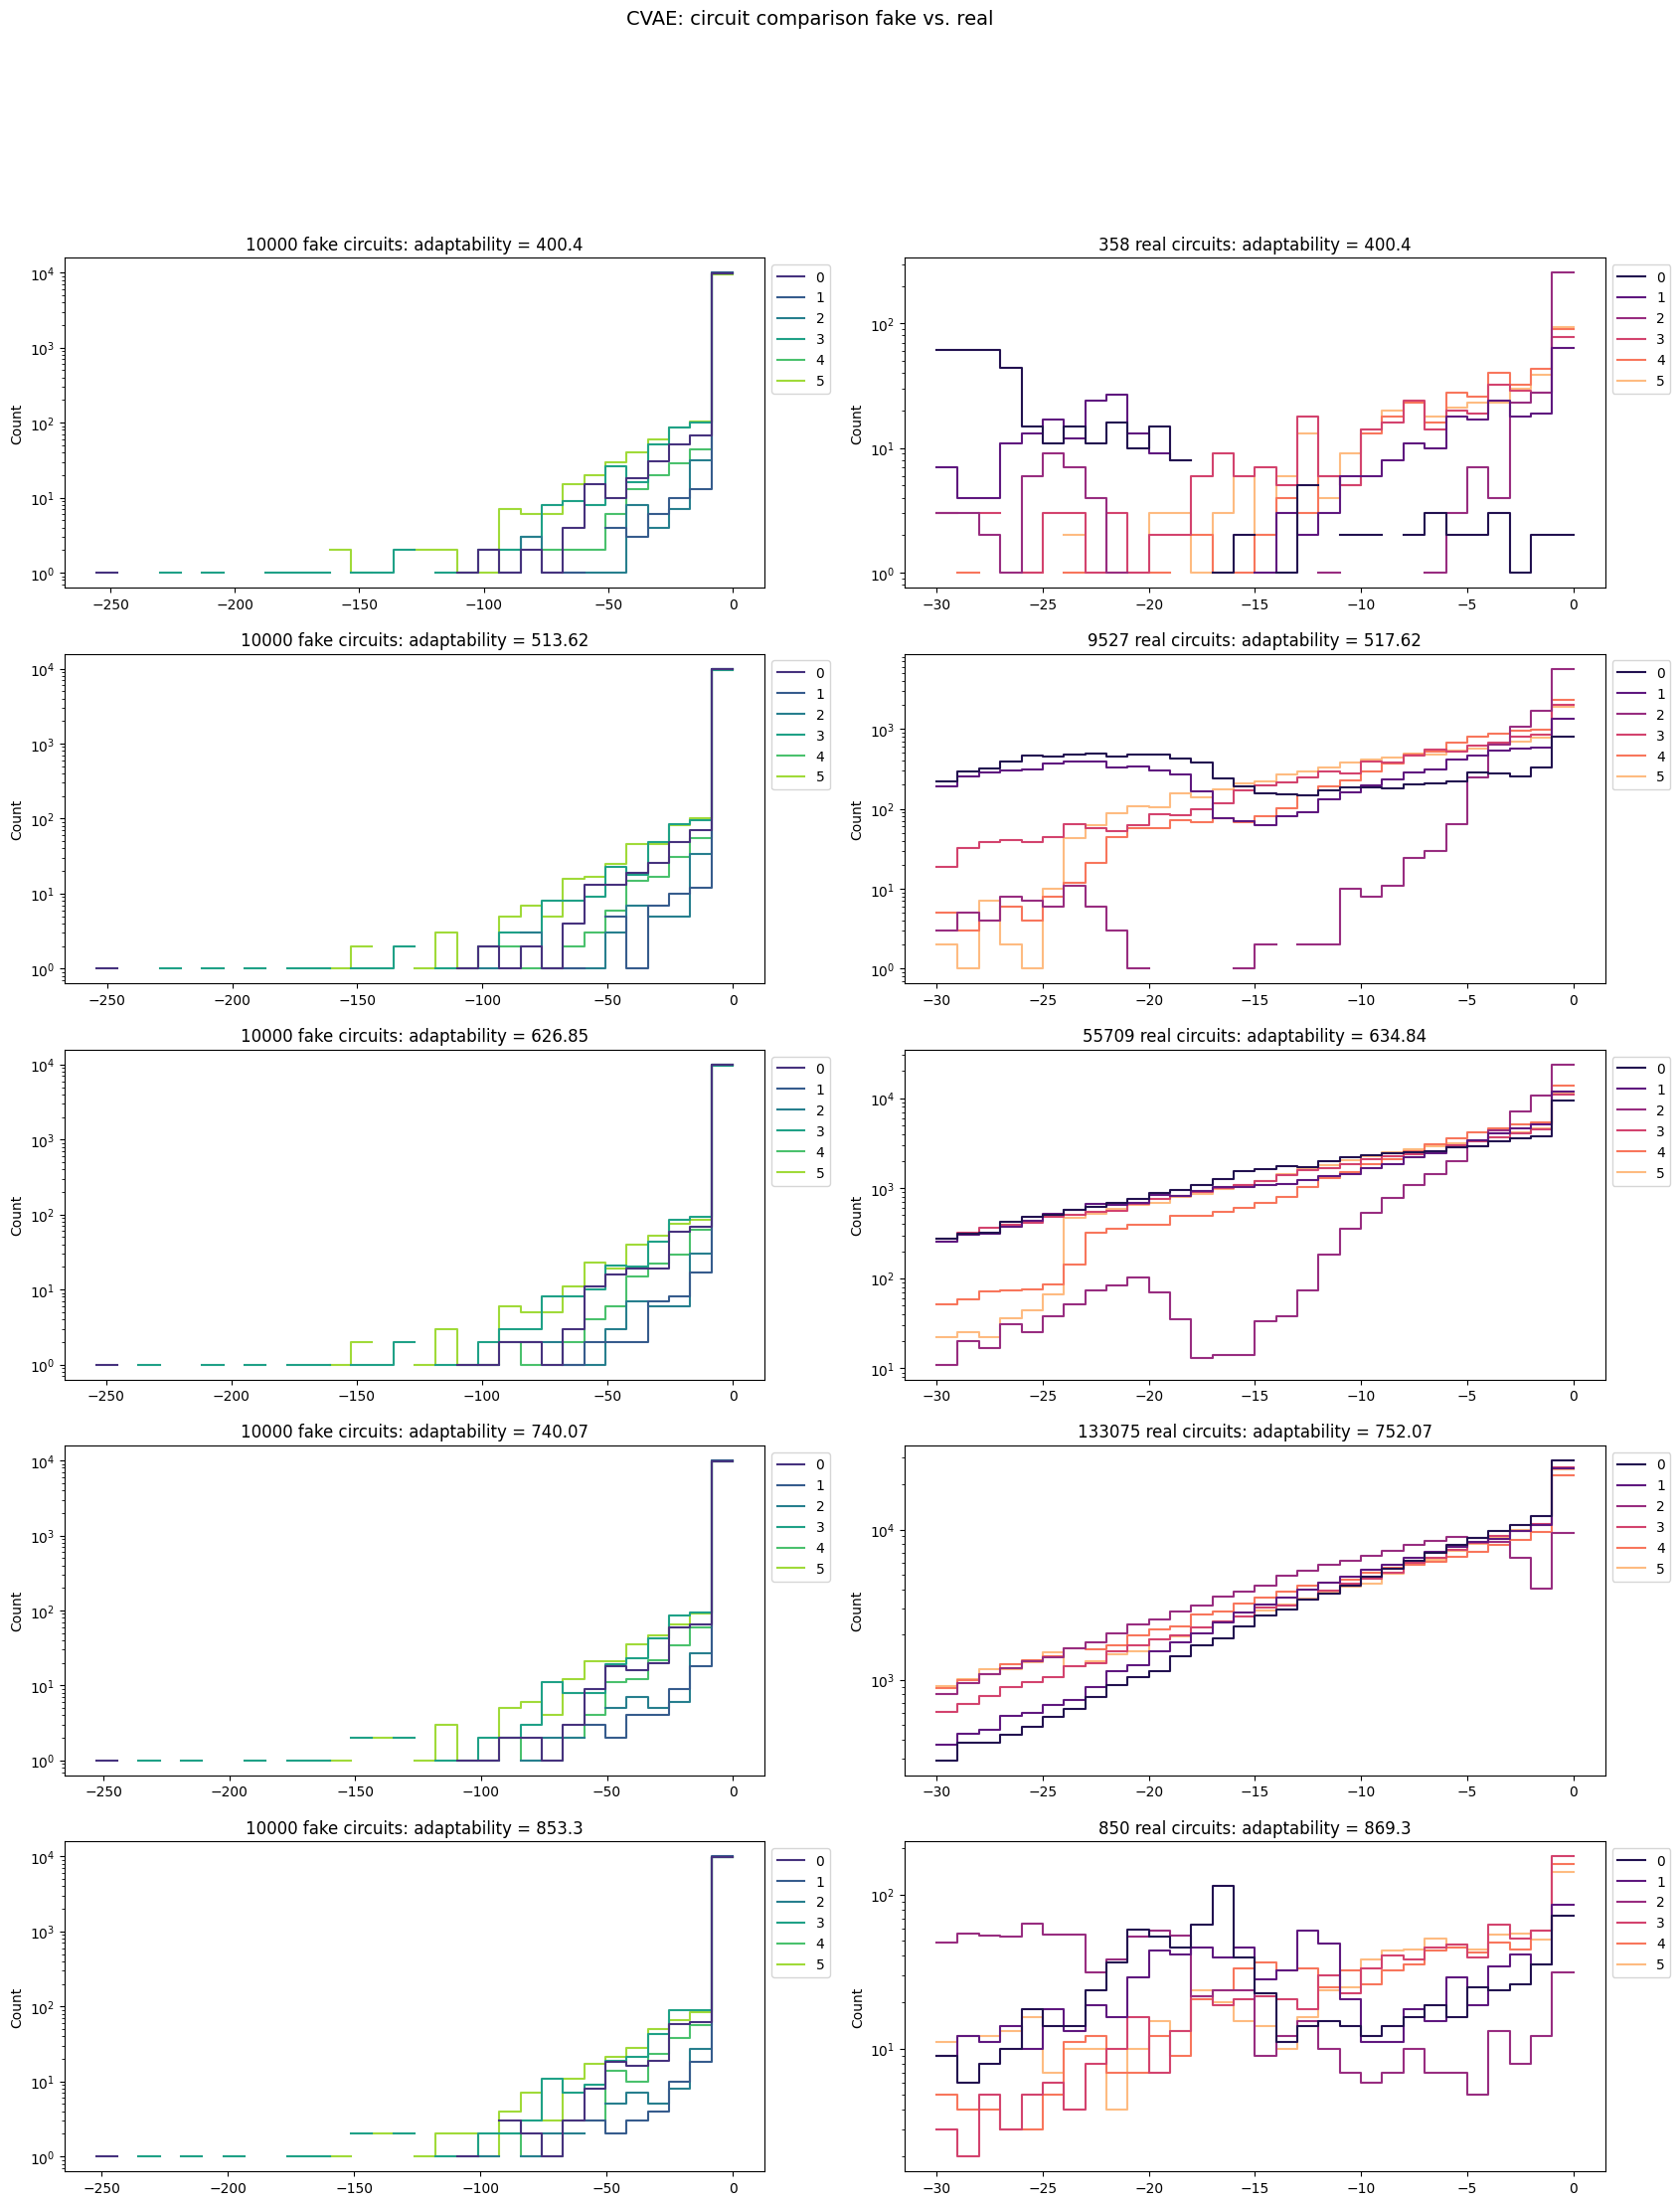

In [48]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True])
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    for y_unscale in y_unscaling:
        sc = y_unscale(sc)
    plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(5, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='layer', fill=False, log_scale=[False, True])
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_xlim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1]])]
    widest_ylim = [np.min([g1.get_ylim()[0], g2.get_ylim()[0]]), np.max([g1.get_ylim()[1], g2.get_ylim()[1]])]
    # g1.set_xlim(widest_xlim)
    # g2.set_ylim(widest_ylim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)